In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/amazon_cells_labelled.txt
/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/imdb_labelled.txt
/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/readme.txt
/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/yelp_labelled.txt


In [2]:
amazon = pd.read_csv('/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/amazon_cells_labelled.txt', 
                     sep='\t',
                     lineterminator='\n',
                     names=['sentance', 'sentiment'] )
imdb = pd.read_csv('/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/imdb_labelled.txt', 
                     sep='\t|\s{3}',
                     lineterminator='\n',
                     names=['sentance', 'sentiment'] )
yelp = pd.read_csv('/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/yelp_labelled.txt', 
                     sep='\t',
                     lineterminator='\n',
                     names=['sentance', 'sentiment'] )
print(f"amazon = {amazon.shape}, imdb = {imdb.shape}, yelp = {yelp.shape}")

amazon = (1000, 2), imdb = (1000, 2), yelp = (1000, 2)


/tmp/ipykernel_20/3939053422.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  imdb = pd.read_csv('/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/imdb_labelled.txt',


In [3]:
data = pd.DataFrame(data=np.concatenate([amazon,imdb,yelp], axis=0), columns=['sentance', 'sentiment'])
data

,sentance,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
2995,I think food should have flavor and texture an...,0
2996,Appetite instantly gone.,0
2997,Overall I was not impressed and would not go b...,0
2998,"The whole experience was underwhelming, and I ...",0


In [4]:
!pip install pyspellchecker

import string
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

sc = SpellChecker()
stemmer = PorterStemmer()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 39.9 MB/s eta 0:00:00


In [5]:
def remove_punc(sentance):
    return sentance.translate(str.maketrans('','',string.punctuation))


def correct(sentance):
    misspelled = sc.unknown(str(sentance).split())
    correct = [sc.correction(w) if w in misspelled else w for w in sentance.split()]
    return " ".join(filter(lambda c : c is not None, correct))


def remove_stop(sentance):
    correct = [w for w in sentance.split() if w not in stopwords.words('english')]
    return " ".join(correct)


def stemming(sentance):
    correct = [stemmer.stem(w) for w in sentance.split()]
    return " ".join(correct)


def remove_numbers(sentance):
    return " ".join([s for s in sentance.split() if not s.isdigit()])

In [6]:
max_words=1500
max_len=200

In [7]:
from keras.utils import pad_sequences

def prepare_data(sentance, tokenizer=None):
    sentance = sentance.lower()
    sentance = remove_punc(sentance)
    sentance = correct(sentance)
    sentance = remove_stop(sentance)
    sentance = stemming(sentance)
    sentance = remove_numbers(sentance)
    if tokenizer is None:
        return sentance
    else: 
        seq = tokenizer.texts_to_sequences([sentance])
        seq_matrix = pad_sequences(seq, maxlen=max_len)
        return seq_matrix.reshape(1,max_len,1)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [8]:
print(remove_punc('What? Where did all the punctuation go????'))
print(correct('its spellinf timr'))
print(remove_stop('There are no longer stop words, so why even bother.'))
print(stemming('It is finally time for some good old stemming shenanigans'))
print(remove_numbers('There were at least 10 numbers here, but 0 are left'))

What Where did all the punctuation go
its spelling time
There longer stop words, even bother.
It is final time for some good old stem shenanigan
There were at least numbers here, but are left


In [9]:
x = data['sentance']
y = data['sentiment']
x

0       So there is no way for me to plug it in here i...
1                             Good case, Excellent value.
2                                  Great for the jawbone.
3       Tied to charger for conversations lasting more...
4                                       The mic is great.
                              ...                        
2995    I think food should have flavor and texture an...
2996                             Appetite instantly gone.
2997    Overall I was not impressed and would not go b...
2998    The whole experience was underwhelming, and I ...
2999    Then, as if I hadn't wasted enough of my life ...
Name: sentance, Length: 3000, dtype: object

In [10]:
x = x.map(lambda x : prepare_data(x))

In [11]:
y = np.asarray(y, dtype='float32')

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1234)

In [13]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_words, oov_token=1)
tokenizer.fit_on_texts(x_train)

train_seq = tokenizer.texts_to_sequences(x_train)
print(len(train_seq))
train_seq_matrix = pad_sequences(train_seq, maxlen=max_len)

test_seq = tokenizer.texts_to_sequences(x_test)
test_seq_matrix = pad_sequences(test_seq, maxlen=max_len)

2400


In [14]:
from keras.layers import LSTM, Embedding, Input, Activation, Dropout, Dense, Bidirectional
from keras.activations import relu, sigmoid
from keras import Model

def make_RNN_model():
    inputs = Input(shape=[max_len])
    layer = Embedding(max_words, 100)(inputs)
    
    layer = Bidirectional(LSTM(128))(layer)
    
    layer = Dense(256)(layer)
    layer = Activation(relu)(layer)
    layer = Dropout(0.8)(layer)
    
    layer = Dense(64)(layer)
    layer = Activation(relu)(layer)
    layer = Dropout(0.8)(layer)
    
    layer = Dense(1)(layer)
    outputs = Activation(sigmoid)(layer)
    
    return Model(inputs=inputs, outputs=outputs)

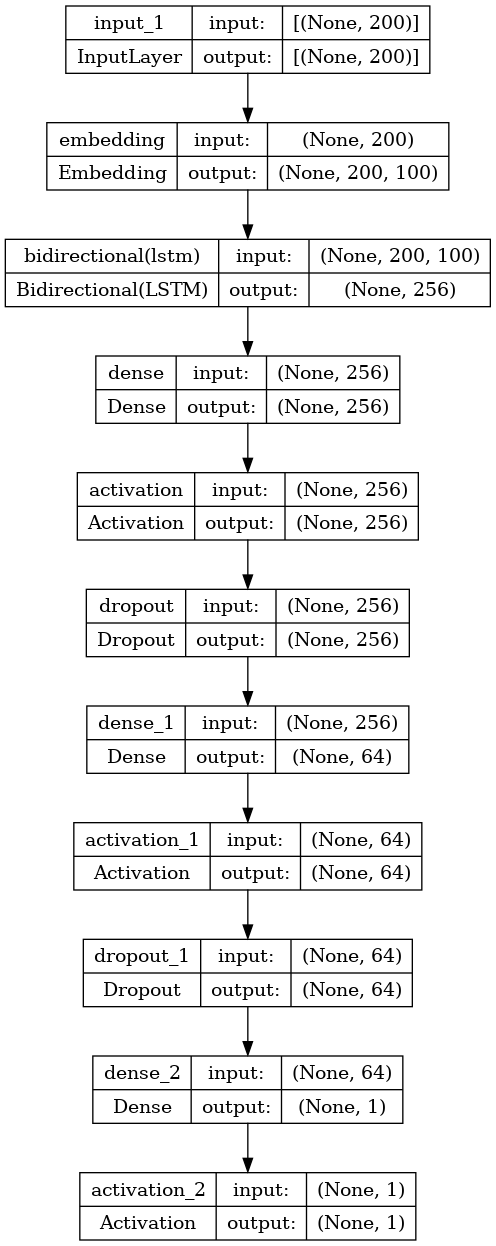

In [15]:
from keras.utils import plot_model

model = make_RNN_model()
plot_model(model, show_shapes=True)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 100)          150000    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [17]:
from keras.optimizers import RMSprop
from keras.metrics import binary_crossentropy
from keras.callbacks import EarlyStopping

model.compile(optimizer=RMSprop(), loss=binary_crossentropy, metrics=['accuracy'])
callback = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001)
history = model.fit(x=train_seq_matrix,
          y=y_train, 
          epochs=100, 
          callbacks=[callback], 
          validation_split=0.2, 
          batch_size=128)

Epoch 1/100
15/15 [==============================] - 15s 742ms/step - loss: 0.6967 - accuracy: 0.4943 - val_loss: 0.6928 - val_accuracy: 0.5042
Epoch 2/100
15/15 [==============================] - 10s 662ms/step - loss: 0.6952 - accuracy: 0.5094 - val_loss: 0.6931 - val_accuracy: 0.4896
Epoch 3/100
15/15 [==============================] - 10s 668ms/step - loss: 0.6947 - accuracy: 0.4885 - val_loss: 0.6911 - val_accuracy: 0.6500
Epoch 4/100
15/15 [==============================] - 10s 676ms/step - loss: 0.6891 - accuracy: 0.5297 - val_loss: 0.6823 - val_accuracy: 0.7354
Epoch 5/100
15/15 [==============================] - 10s 668ms/step - loss: 0.6437 - accuracy: 0.6583 - val_loss: 0.5788 - val_accuracy: 0.7521
Epoch 6/100
15/15 [==============================] - 10s 693ms/step - loss: 0.5100 - accuracy: 0.7896 - val_loss: 0.4969 - val_accuracy: 0.7563
Epoch 7/100
15/15 [==============================] - 10s 666ms/step - loss: 0.3850 - accuracy: 0.8552 - val_loss: 0.4895 - val_accuracy:

In [18]:
model.evaluate(test_seq_matrix, y_test)

19/19 [==============================] - 2s 103ms/step - loss: 1.5824 - accuracy: 0.7517


[1.5823925733566284, 0.7516666650772095]

In [19]:
tokenizer.texts_to_sequences('it was great')

[[1], [1], [], [1], [1], [1], [], [1], [1], [1], [1], [1]]

In [20]:
print(train_seq[0])

[1, 131, 82, 1, 633, 44, 517, 518, 1045, 31, 48, 518, 8, 1, 121, 1046]


In [21]:
dict = {0 : 'negative', 1 : 'positive'}


def predict(sentance, tokenizer, model):
    seq = prepare_data(sentance, tokenizer=tokenizer)
    pred = model.predict(seq).item()
    print(pred)
    prediction = np.round(pred)
    return dict.get(prediction)

In [22]:
predict('I am not really sure, but i was not happy with the performance overall', tokenizer, model)

1/1 [==============================] - 1s 836ms/step
0.9558872580528259


'positive'